In [23]:
import random

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


class Agent:
  statuses = ['S', 'I', 'R', 'D']

  def __init__(self, position, status, has_mask, is_distancing):
    self.position = position
    self.status = status
    self.counter = -1
    self.mask = has_mask
    self.distancing = is_distancing
    if status == "I":
        self.counter = 0
    return

 
class ABM:
  directions = [[-1,0], # left
                [1,0], # right
                [0,-1], # up
                [0,1], # down
                [-1,-1], # left & up
                [-1,1], # left & down
                [1,-1], # right & up
                [1,1]] # right & down

  statusColors = {'R': 'green', 'S': 'blue', 'I': 'red', 'D': 'black'}

  def __init__(self, world_size, num_agents, num_infected, percent_distancing, percent_mask, percent_vaccinated):
    self.world = []
    for i in range(world_size):
        self.world.append([-1] * world_size)
    self.agents = []
    num_I, num_R = num_infected, num_agents * percent_vaccinated
    num_S = num_agents - (num_I + num_R)
    num_dist, num_mask = num_agents * percent_distancing, num_agents * percent_mask
    print_dist, print_mask = 0, 0
    occupied = set()
    for i in range(num_agents):
        agents_left = num_S + num_I + num_R
        position = (random.randint(1, world_size), random.randint(1, world_size))
        while position in occupied:
            position = (random.randint(1, world_size), random.randint(1, world_size))
            
        occupied.add(position)
        
        state = random.randint(1, agents_left)
        
        if state <= num_I:
            status = "I"
            num_I -= 1
        elif state <= num_R:
            status = "R"
            num_R -= 1
        else:
            status = "S"
            num_S -= 1
            
        social_dist = False
        dist = random.randint(1, agents_left)
        if dist <= num_dist:
            social_dist = True
            num_dist -= 1
            
        social_mask = False
        mask = random.randint(1, agents_left)
        if mask <= num_mask:
            social_mask = True
            num_mask -= 1
            
        new_agent = Agent(position, status, social_mask, social_dist)
        self.agents.append(new_agent)
        self.world[position[0]-1][position[1]-1] = i

    self.num_recovered, self.num_dead, self.num_infected, self.num_susceptible = \
        num_agents * percent_vaccinated, 0, num_infected, num_agents - (num_agents * percent_vaccinated + num_infected)
    self.positions = []
    self.counts = {}
    for key in Agent.statuses:
      self.counts[key] = []
       
  def validDirections(self, position, index):
    xi, yi = position
    neighbors = [[xi+xf, yi+yf] for xf, yf in ABM.directions]
    n = len(self.world)
    for i in range(len(neighbors)):
        x, y = neighbors[i]
        if x == n:
            neighbors[i][0] = 0
        if x == -1:
            neighbors[i][0] = n-1
        if y == n:
            neighbors[i][1] = 0
        if y == -1:
            neighbors[i][1] = n-1
    new_neighbors = []
    for x, y in neighbors:
        if self.world[x][y] < 0 or self.world[x][y] == index:
            new_neighbors.append([x, y])
    return new_neighbors

  def adjacentToI(self, position, index):
    xi, yi = position
    neighbors = [[xi+xf, yi+yf] for xf, yf in ABM.directions]
    n = len(self.world)
    for i in range(len(neighbors)):
        x, y = neighbors[i]
        if x == n:
            neighbors[i][0] = 0
        if x == -1:
            neighbors[i][0] = n-1
        if y == n:
            neighbors[i][1] = 0
        if y == -1:
            neighbors[i][1] = n-1
    mask = []
    for x, y in neighbors:
        agent_index = self.world[x][y]
        agent = self.agents[agent_index]
        if agent.status == "I" and ((agent_index < index and agent.counter >= 1) or agent_index > index):
            mask.append(agent.mask)
    return mask
    
  def moveAgent(self, agent):
    if agent.status == "D":
        return
    x, y = agent.position
    index = self.world[x-1][y-1]
    valid_moves = self.validDirections((x-1, y-1), index)
    new_valid_moves = []
    if agent.distancing:
        for xi, yi in valid_moves:
            if len(self.validDirections((xi, yi), index)) == 8:
                new_valid_moves.append([xi, yi])
    else:
        new_valid_moves = valid_moves.copy()
    
    if new_valid_moves:
        move_index = random.randint(0, len(new_valid_moves)-1)
        move = new_valid_moves[move_index]
        new_position = (move[0]+1, move[1]+1)
        agent.position = new_position
        self.world[x-1][y-1] = -1
        self.world[move[0]][move[1]] = index
    
    if agent.status == "S":
        adjacentMaskList = self.adjacentToI((agent.position[0]-1, agent.position[1]-1), index)
        for adjacentMask in adjacentMaskList:
            twoMasks, oneMask = adjacentMask and agent.mask, adjacentMask or agent.mask
            # both masked rate: 1%
            if twoMasks:
                infectionRate = random.randint(1, 300)
            # one is masked rate: 5%
            elif oneMask:
                infectionRate = random.randint(1, 60)
            # neither are masked rate: 50%
            else:
                infectionRate = random.randint(1, 6)
            
            if infectionRate <= 3:
                agent.status = "I"
                agent.counter = 0
                if random.randint(1, 5) < 5:
                    agent.symptomatic = True
                self.num_infected += 1
                self.num_susceptible -= 1
                break
                
    elif agent.status == "I":
        agent.counter += 1
        status = agent.status
        if agent.counter > 14:
            # death rate for infectious agent: 10%
            if random.randint(1, 10) == 1:
                agent.status = "D"
                x, y = agent.position[0]-1, agent.position[1]-1
                self.world[x][y] = -1
                self.num_dead += 1
                self.num_infected -= 1
            else:
                agent.status = "R"
                self.num_recovered += 1
                self.num_infected -= 1
    return

  def addCounts(self):
    self.counts["S"].append(self.num_susceptible)
    self.counts["I"].append(self.num_infected)
    self.counts["R"].append(self.num_recovered)
    self.counts["D"].append(self.num_dead)

  def appendPositions(self):
    positionInfo = []
    for agent in self.agents:
        if agent.status != "D":
            positionInfo.append((agent.position, agent.status))
    self.positions.append(positionInfo)

  def runSimulation(self, num_steps):
    for t in range(num_steps):
      for agent in self.agents:
        self.moveAgent(agent)

      self.addCounts()
      self.appendPositions()
    
    return self.counts, self.positions      




In [34]:
### EDIT
def runAndPlotSimulations(num_steps, world_size, num_agents, num_infected, percent_distancing, percent_mask, percent_vaccinated):
    model = ABM(world_size, num_agents, num_infected, percent_distancing, percent_mask, percent_vaccinated)
    sim_counts, sim_positions = model.runSimulation(num_steps)
    scatter_positions = []
    for positions in sim_positions:
        x, y, c = [], [], []
        for (position, status) in positions:
            color = ABM.statusColors[status]
            x.append(position[0])
            y.append(position[1])
            c.append(color)
        scatter_positions.append([x, y, c])
        
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(1,1,1)

    for i in range(len(scatter_positions)):
        positions = scatter_positions[i]
        
        ax.cla()
        
        ax.scatter(positions[0], positions[1], c=positions[2])

        ax.set_xticks(list(range(world_size+2)))
        ax.set_yticks(list(range(world_size+2)))  

        display(fig)
        if i != (len(scatter_positions) - 1):
            clear_output(wait=True)
    
    fig, ax = plt.subplots(figsize=(20,10))
    x = [i for i in range(num_steps)]
    for status in sim_counts:
        ax.plot(x, sim_counts[status], color=ABM.statusColors[status], label=status)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
        

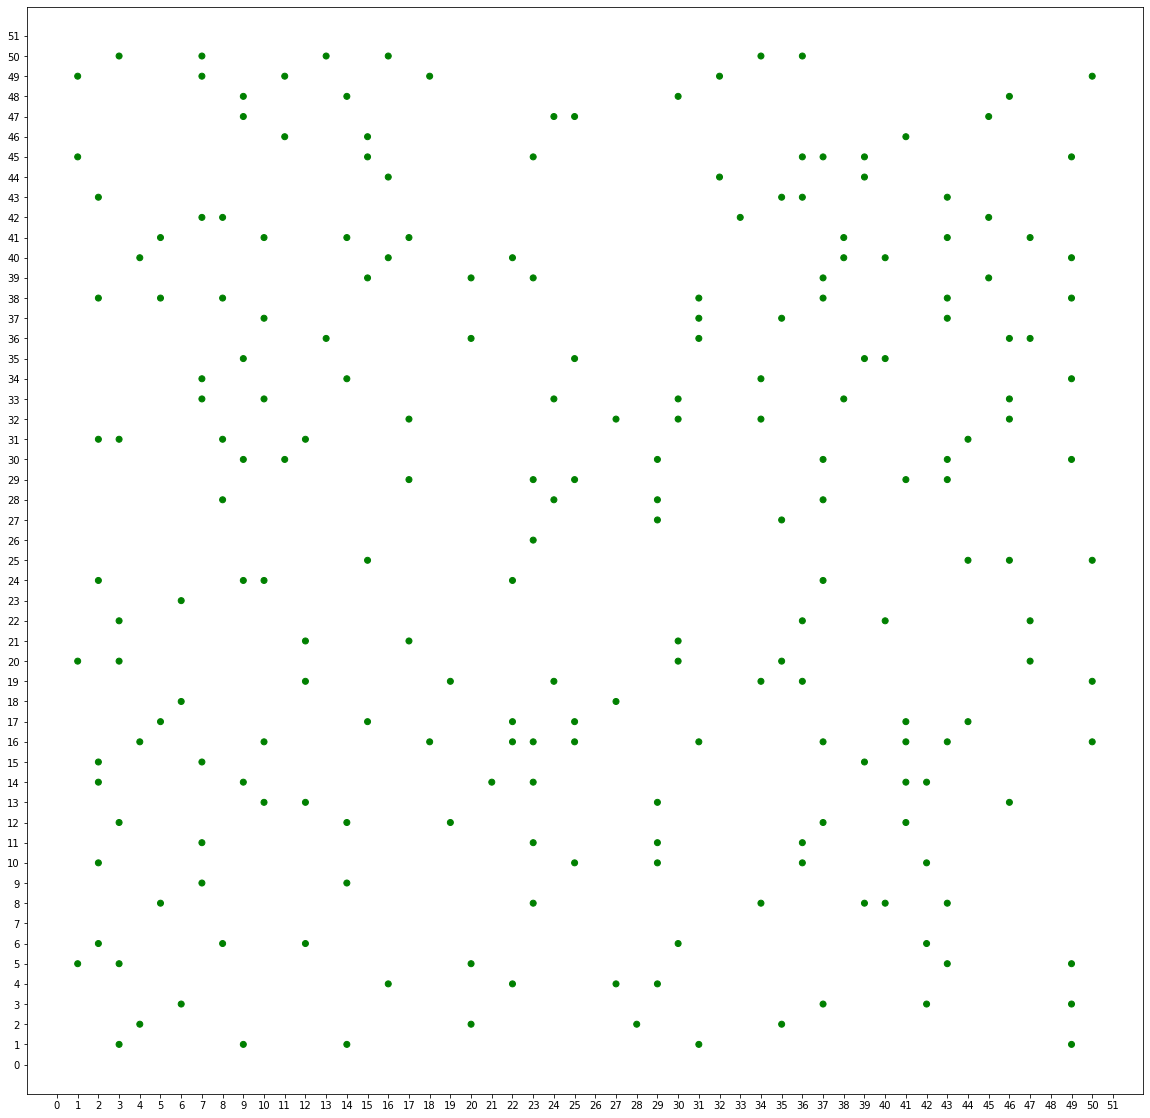

AttributeError: 'Line2D' object has no property 'fmt'

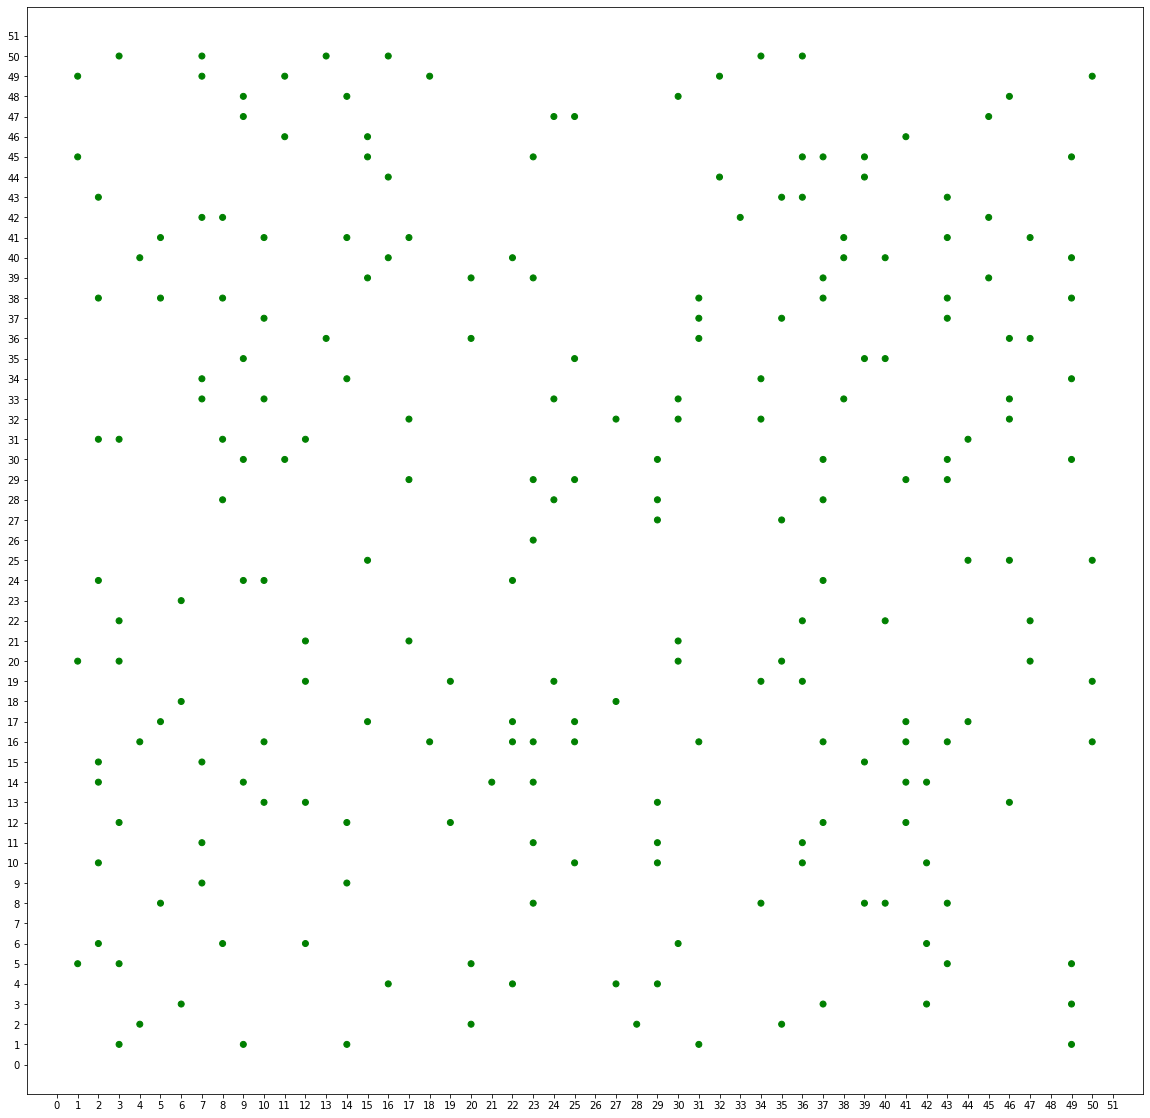

<Figure size 1440x720 with 0 Axes>

In [40]:
runAndPlotSimulations(365, 50, 250, 5, 0, 0, 0)

In [38]:
runAndPlotSimulations(10, 365, 25, 250, 5, .3, .3, 0)

TypeError: runAndPlotSimulations() takes 7 positional arguments but 8 were given

Average R: 210.4 Average I + Q Peak: 111.5 Average I + Q Extinct: 50.6


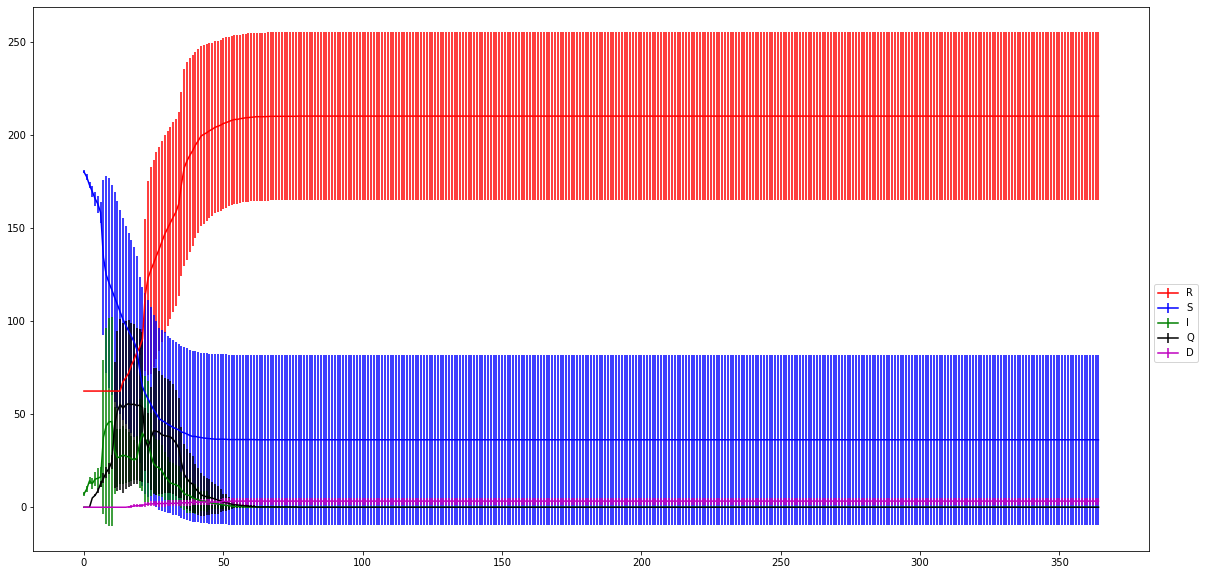

In [23]:
runAndPlotSimulations(10, 365, 25, 250, 5, 0, 0, .25)